In [1]:
# Data from here:
# https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from adjustText import adjust_text
from matplotlib.ticker import ScalarFormatter

import glob
import os

C:\Programing_Language\Anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# READ, RENAME
covid = pd.read_excel("COVID-19-geographic-disbtribution-worldwide-2020-08-27.xlsx")
# REPLACED WITH THE CODE BELOW THAT EXTRACTS THE LATEST .xlsx FILE IN THE FOLDER

# list_of_files = glob.glob('C:\\Users\\nikan\\Desktop\\COVID_daily/*xlsx') # * means all if need specific format then *.csv
# latest_file = max(list_of_files, key=os.path.getctime)
# print(latest_file)
# covid = pd.read_excel(latest_file) 

covid.rename(columns = {'dateRep': 'DateRep', 'day':'Day', 'month':'Month','year':'Year','cases':'Cases','deaths':'Deaths', 'popData2019':'Population', 'countriesAndTerritories': 'Country', 'continentExp':'Continent'}, inplace = True)

In [3]:
covid_daily_per_continent = covid.groupby(['DateRep','Continent'])[['Cases', 'Deaths']].sum()

In [4]:
covid_daily_per_continent_cumulative = covid_daily_per_continent.groupby(['Continent']).cumsum()
covid_daily_per_continent.reset_index(inplace=True)
covid_daily_per_continent_cumulative.reset_index(inplace=True)

In [5]:
covid_daily_global = covid.groupby(['DateRep'])[['Cases', 'Deaths']].sum()
covid_daily_global.reset_index(inplace=True)

In [6]:
covid_daily_global_cumulative = covid.groupby(['DateRep'])[['Cases', 'Deaths']].sum().cumsum()
covid_daily_global_cumulative.reset_index(inplace=True)

In [7]:
# TO CONVERT THE MILLIONS IN THE Y-AXIS TO 1M, 2M, etc
from matplotlib.ticker import FuncFormatter
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x * 1e-6)
formatter_mil = FuncFormatter(millions)

# TO CONVERT THE THOUSANDS IN THE Y-AXIS TO 1K, 2K, etc
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x * 1e-3)
formatter_kil = FuncFormatter(thousands)

In [8]:
# TO PLOT MTH IN THE X-AXIS
# Set the locator
locator = mdates.MonthLocator()  # every month
# Specify the format - %b gives us Jan, Feb...
fmt = mdates.DateFormatter('%b')

In [9]:
last_day_covid = covid_daily_per_continent[covid_daily_per_continent['DateRep'] == covid_daily_per_continent['DateRep'].max()]
last_day_covid_cumulative = covid_daily_per_continent_cumulative[covid_daily_per_continent_cumulative['DateRep'] == covid_daily_per_continent_cumulative['DateRep'].max()]
continents = last_day_covid['Continent'].to_list()

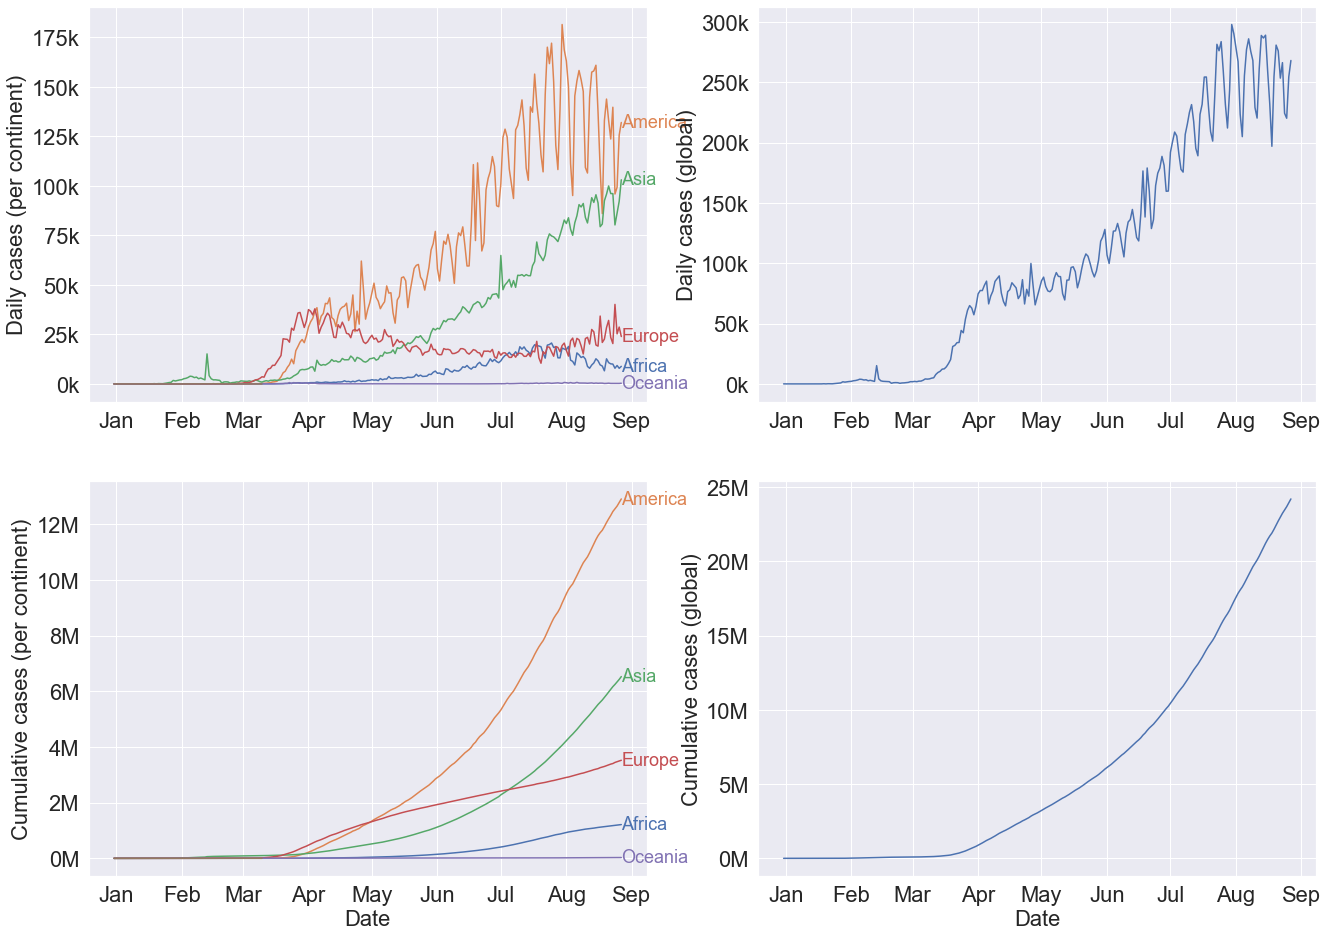

In [10]:
sns.set(rc={'figure.figsize':(22,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)
ax1 = sns.lineplot(x="DateRep", y="Cases", hue="Continent", data=covid_daily_per_continent, markers=True, legend=False, ax=axes[0, 0]) #, hue_order=countries_1_5
texts1 = [axes[0, 0].text(last_day_covid.loc[last_day_covid['Continent'] == str(continent)]['DateRep'], last_day_covid.loc[last_day_covid['Continent'] == str(continent)]['Cases'], str(continent), fontsize=18, color=ax1.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
# adjust_text(texts)
axes[0, 0].set_ylabel("Daily cases (per continent)",fontsize=22)
axes[0, 0].set_xlabel("",fontsize=22)
ax1.yaxis.set_major_formatter(formatter_kil)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(fmt)

ax2 = sns.lineplot(x="DateRep", y="Cases", hue="Continent", data=covid_daily_per_continent_cumulative, markers=True, legend=False, ax=axes[1, 0]) #, hue_order=countries_1_5
texts2 = [axes[1, 0].text(last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['DateRep'], last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['Cases'], str(continent), fontsize=18, color=ax2.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
axes[1, 0].set_ylabel("Cumulative cases (per continent)",fontsize=22)
axes[1, 0].set_xlabel("Date",fontsize=22)
ax2.yaxis.set_major_formatter(formatter_mil)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(fmt)

ax3 = sns.lineplot(x="DateRep", y="Cases", data=covid_daily_global, markers=True, legend=False, ax=axes[0, 1]) 
axes[0, 1].set_ylabel("Daily cases (global)",fontsize=22)
axes[0, 1].set_xlabel("",fontsize=22)
ax3.yaxis.set_major_formatter(formatter_kil)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(fmt)

ax4 = sns.lineplot(x="DateRep", y="Cases", data=covid_daily_global_cumulative, markers=True, legend=False, ax=axes[1, 1]) 
axes[1, 1].set_ylabel("Cumulative cases (global)",fontsize=22)
axes[1, 1].set_xlabel("Date",fontsize=22)
ax4.yaxis.set_major_formatter(formatter_mil)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(fmt)

plt.show('covid_h_Infection_rate_per_continent.png')

#### Task #4: Smoothing the noisy data - Fig_4_1

In [11]:
continents = ['Europe','America','Africa','Oceania','Asia']

# back_calc IS THE BACK WINDOW THAT IS USED TO CALCULATE THE SLOPE
back_calc = 7
slope_df = pd.DataFrame(columns=['Continent', 'Days_from_0', 'Slope','Intercept', 'R2', 'P_value','DateRep','Cases'])
for continent in continents:
    one_continent_data = covid_daily_per_continent[covid_daily_per_continent['Continent'] == str(continent)].reset_index(drop=True)
    one_continent_data['Days_from_0'] = (one_continent_data['DateRep'] - one_continent_data.loc[0,'DateRep']).dt.days
 
    for i in np.arange(back_calc, len(one_continent_data)+1):
        x = one_continent_data.loc[i-back_calc: i, 'Days_from_0'] # That is the 'DateRep'
        y = one_continent_data.loc[i-back_calc: i, 'Cases'] # 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        one_continent_data.loc[i-1, 'Slope'] = slope
        one_continent_data.loc[i-1, 'Intercept'] = intercept
        one_continent_data.loc[i-1, 'R2'] = r_value * r_value
        one_continent_data.loc[i-1, 'P_value'] = p_value
        one_continent = one_continent_data[['Continent', 'Days_from_0', 'Slope','Intercept', 'R2', 'P_value','DateRep','Cases']]
        
    slope_df = slope_df.append(one_continent, ignore_index=False)

slope_df['regLine'] = slope_df['Intercept'] + slope_df['Slope']*slope_df['Days_from_0']
slope_df=slope_df.reset_index()
slope_df

C:\Users\alexl\AppData\Local\Temp\ipykernel_48584\680132276.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slope_df = slope_df.append(one_continent, ignore_index=False)
C:\Users\alexl\AppData\Local\Temp\ipykernel_48584\680132276.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slope_df = slope_df.append(one_continent, ignore_index=False)
C:\Users\alexl\AppData\Local\Temp\ipykernel_48584\680132276.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slope_df = slope_df.append(one_continent, ignore_index=False)
C:\Users\alexl\AppData\Local\Temp\ipykernel_48584\680132276.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slope_

,index,Continent,Days_from_0,Slope,Intercept,R2,P_value,DateRep,Cases,regLine
0,0,Europe,0,NaN,NaN,NaN,NaN,2019-12-31 00:00:00,0,NaN
1,1,Europe,1,NaN,NaN,NaN,NaN,2020-01-01 00:00:00,0,NaN
2,2,Europe,2,NaN,NaN,NaN,NaN,2020-01-02 00:00:00,0,NaN
3,3,Europe,3,NaN,NaN,NaN,NaN,2020-01-03 00:00:00,0,NaN
4,4,Europe,4,NaN,NaN,NaN,NaN,2020-01-04 00:00:00,0,NaN
...,...,...,...,...,...,...,...,...,...,...
1200,236,Asia,236,1167.988095,-182612.845238,0.113113,0.415335,2020-08-23 00:00:00,96103,93032.345238
1201,237,Asia,237,-304.511905,162376.916667,0.009722,0.816321,2020-08-24 00:00:00,80284,90207.595238
1202,238,Asia,238,-1295.404762,397472.321429,0.25072,0.206273,2020-08-25 00:00:00,86236,89165.988095
1203,239,Asia,239,-394.202381,186954.738095,0.017124,0.757426,2020-08-26 00:00:00,92227,92740.369048


In [12]:
covid_daily_global_4 = slope_df.groupby(['DateRep'])[['regLine']].sum()
covid_daily_global_4.reset_index(inplace=True)

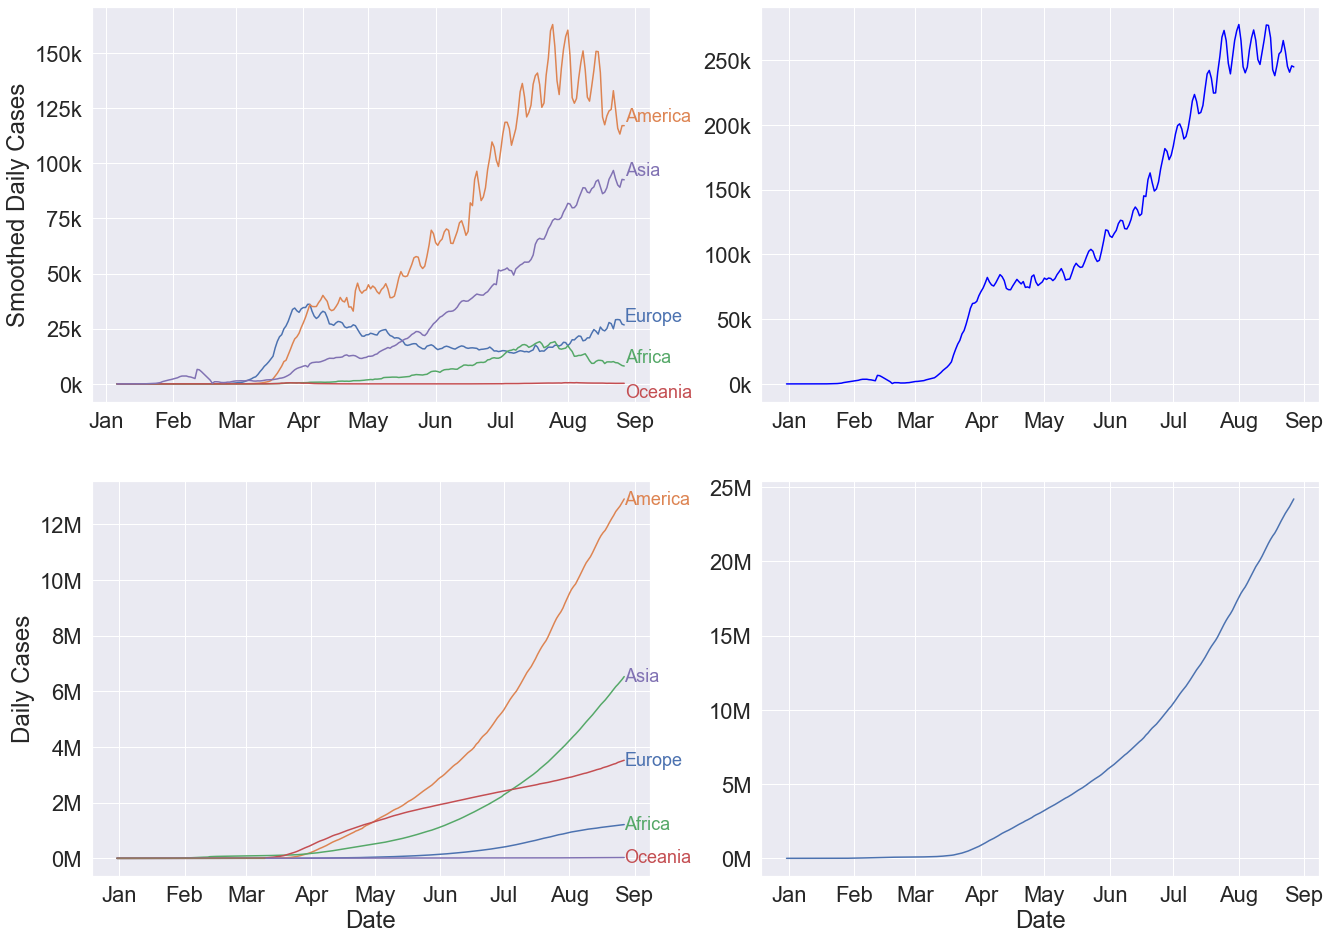

In [13]:
sns.set(rc={'figure.figsize':(22,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

ax1 = sns.lineplot(x="DateRep", y="regLine", hue="Continent", data=slope_df, markers=True, legend=False, ax=axes[0, 0])
texts1 = [axes[0, 0].text(slope_df[slope_df['Continent']==continent].iloc[slope_df[slope_df['Continent']==continent].shape[0]-1]['DateRep'], slope_df[slope_df['Continent']==continent].iloc[slope_df[slope_df['Continent']==continent].shape[0]-1]['regLine'], str(continent), fontsize=18, color=ax1.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
adjust_text(texts1)
ax1.yaxis.set_major_formatter(formatter_kil)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(fmt)


ax2 = sns.lineplot(x="DateRep", y="regLine", data=covid_daily_global_4, markers=True, legend=False, ax=axes[0, 1],color='blue') 
ax2.yaxis.set_major_formatter(formatter_kil)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(fmt)


ax3 = sns.lineplot(x="DateRep", y="Cases", hue="Continent", data=covid_daily_per_continent_cumulative, markers=True, legend=False, ax=axes[1, 0]) #, hue_order=countries_1_5
texts3 = [axes[1, 0].text(last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['DateRep'], last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['Cases'], str(continent), fontsize=18, color=ax3.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
axes[1, 0].set_ylabel("Cumulative cases (per continent)",fontsize=22)
axes[1, 0].set_xlabel("Date",fontsize=22)
ax3.yaxis.set_major_formatter(formatter_mil)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(fmt)


ax4 = sns.lineplot(x="DateRep", y="Cases", data=covid_daily_global_cumulative, markers=True, legend=False, ax=axes[1, 1]) 
axes[1, 1].set_ylabel("Cumulative cases (global)",fontsize=22)
axes[1, 1].set_xlabel("Date",fontsize=22)
ax4.yaxis.set_major_formatter(formatter_mil)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(fmt)

axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 0].set_ylabel("Smoothed Daily Cases",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_ylabel("",fontsize=24)
axes[1, 0].set_ylabel("Daily Cases",fontsize=24)
axes[1, 1].set_ylabel("",fontsize=24)
axes[1, 1].set_xlabel("Date",fontsize=24)
axes[1, 0].set_xlabel("Date",fontsize=24)

plt.savefig('Fig_4_1_ZHANG_YANBIN')

#### Task #4: Smoothing the noisy data - Fig_4_2

In [14]:
continents = ['Europe','America','Africa','Oceania','Asia']

# back_calc IS THE BACK WINDOW THAT IS USED TO CALCULATE THE SLOPE
back_calc = 7
slope_df = pd.DataFrame(columns=['Continent', 'Days_from_0', 'Slope','Intercept', 'R2', 'P_value','DateRep','Deaths'])
for continent in continents:
    one_continent_data = covid_daily_per_continent[covid_daily_per_continent['Continent'] == str(continent)].reset_index(drop=True)
    one_continent_data['Days_from_0'] = (one_continent_data['DateRep'] - one_continent_data.loc[0,'DateRep']).dt.days
 
    for i in np.arange(back_calc, len(one_continent_data)+1):
        x = one_continent_data.loc[i-back_calc: i, 'Days_from_0'] # That is the 'DateRep'
        y = one_continent_data.loc[i-back_calc: i, 'Deaths'] # 
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        one_continent_data.loc[i-1, 'Slope'] = slope
        one_continent_data.loc[i-1, 'Intercept'] = intercept
        one_continent_data.loc[i-1, 'R2'] = r_value * r_value
        one_continent_data.loc[i-1, 'P_value'] = p_value
        one_continent = one_continent_data[['Continent', 'Days_from_0', 'Slope','Intercept', 'R2', 'P_value','DateRep','Deaths']]
        
    slope_df = slope_df.append(one_continent, ignore_index=False)

slope_df['regLine'] = slope_df['Intercept'] + slope_df['Slope']*slope_df['Days_from_0']
slope_df=slope_df.reset_index()

C:\Users\alexl\AppData\Local\Temp\ipykernel_48584\1365304393.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slope_df = slope_df.append(one_continent, ignore_index=False)
C:\Users\alexl\AppData\Local\Temp\ipykernel_48584\1365304393.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slope_df = slope_df.append(one_continent, ignore_index=False)
C:\Users\alexl\AppData\Local\Temp\ipykernel_48584\1365304393.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  slope_df = slope_df.append(one_continent, ignore_index=False)
C:\Users\alexl\AppData\Local\Temp\ipykernel_48584\1365304393.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sl

In [15]:
covid_daily_global_4_2 = slope_df.groupby(['DateRep'])[['regLine']].sum()
covid_daily_global_4_2.reset_index(inplace=True)

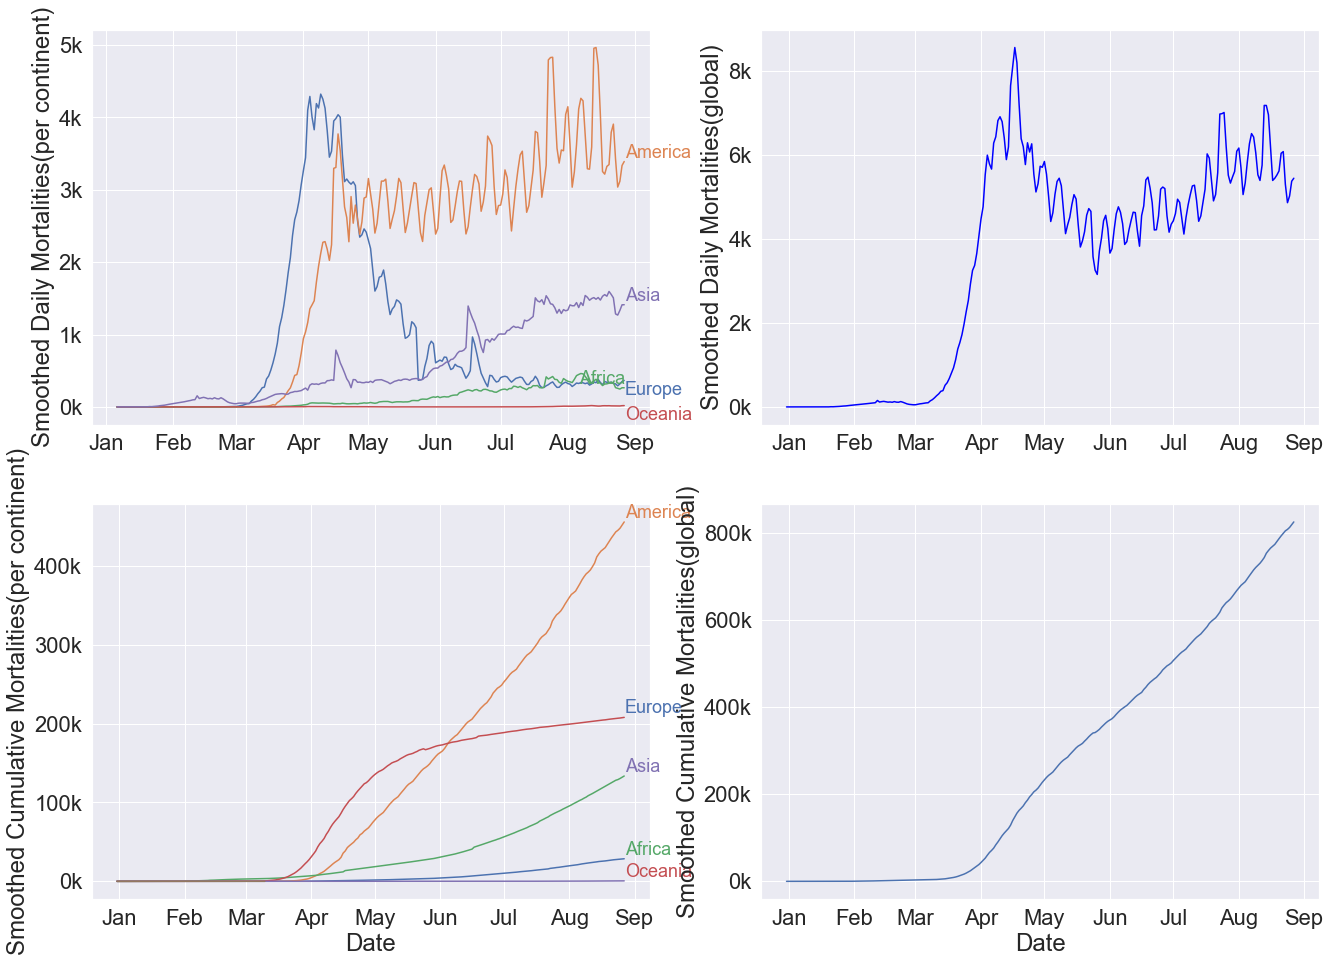

In [16]:
sns.set(rc={'figure.figsize':(22,16)}, font_scale = 2)
fig, axes = plt.subplots(2, 2)

ax1 = sns.lineplot(x="DateRep", y="regLine", hue="Continent", data=slope_df, markers=True, legend=False, ax=axes[0, 0])
texts1 = [axes[0, 0].text(slope_df[slope_df['Continent']==continent].iloc[slope_df[slope_df['Continent']==continent].shape[0]-1]['DateRep'], slope_df[slope_df['Continent']==continent].iloc[slope_df[slope_df['Continent']==continent].shape[0]-1]['regLine'], str(continent), fontsize=18, color=ax1.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
adjust_text(texts1)
ax1.yaxis.set_major_formatter(formatter_kil)
ax1.xaxis.set_major_locator(locator)
ax1.xaxis.set_major_formatter(fmt)

ax2 = sns.lineplot(x="DateRep", y="regLine", data=covid_daily_global_4_2, markers=True, legend=False, ax=axes[0, 1],color='blue') 
ax2.yaxis.set_major_formatter(formatter_kil)
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(fmt)

ax3 = sns.lineplot(x="DateRep", y="Deaths", hue="Continent", data=covid_daily_per_continent_cumulative, markers=True, legend=False, ax=axes[1, 0]) #, hue_order=countries_1_5
texts3 = [axes[1, 0].text(last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['DateRep'], last_day_covid_cumulative.loc[last_day_covid_cumulative['Continent'] == str(continent)]['Deaths'], str(continent), fontsize=18, color=ax3.get_lines()[continents.index(continent)].get_c(), ha = 'left', va = 'center') for continent in continents]
adjust_text(texts3)
axes[1, 0].set_ylabel("Cumulative Deaths (per continent)",fontsize=22)
axes[1, 0].set_xlabel("Date",fontsize=22)
ax3.yaxis.set_major_formatter(formatter_kil)
ax3.xaxis.set_major_locator(locator)
ax3.xaxis.set_major_formatter(fmt)


ax4 = sns.lineplot(x="DateRep", y="Deaths", data=covid_daily_global_cumulative, markers=True, legend=False, ax=axes[1, 1]) 
axes[1, 1].set_ylabel("Cumulative deaths (global)",fontsize=22)
axes[1, 1].set_xlabel("Date",fontsize=22)
ax4.yaxis.set_major_formatter(formatter_kil)
ax4.xaxis.set_major_locator(locator)
ax4.xaxis.set_major_formatter(fmt)


axes[0, 0].set_xlabel("",fontsize=24)
axes[0, 0].set_ylabel("Smoothed Daily Mortalities(per continent)",fontsize=24)
axes[0, 1].set_xlabel("",fontsize=24)
axes[0, 1].set_ylabel("Smoothed Daily Mortalities(global)",fontsize=24)
axes[1, 0].set_ylabel("Smoothed Cumulative Mortalities(per continent)",fontsize=24)
axes[1, 1].set_ylabel("Smoothed Cumulative Mortalities(global)",fontsize=24)
axes[1, 1].set_xlabel("Date",fontsize=24)
axes[1, 0].set_xlabel("Date",fontsize=24)



plt.savefig('Fig_4_2_ZHANG_YANBIN')